In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 
# Permite mostrar el resultado de cada linea de la misma celda

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import keras

from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist


## Autoencoder

Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. The code is a compact “summary” or “compression” of the input, also called the latent-space representation or bottleneck.

<img src="autoencoder.jpg">
<img src="AutoEncoder.png">

Autoencoders are mainly a dimensionality reduction algorithm with a couple of important properties:

1. Data-specific: Autoencoders are only able to meaningfully compress data similar to what they have been trained on. Since they learn features specific for the given training data, they are different than a standard data compression algorithm like gzip. So we can’t expect an autoencoder trained on handwritten digits to compress landscape photos.

2. Lossy: The output of the autoencoder will not be exactly the same as the input, it will be a close but degraded representation. If you want lossless compression they are not the way to go.

3. Unsupervised: To train an autoencoder we don’t need to do anything fancy, just throw the raw input data at it. Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on. But to be more precise they are self-supervised because they generate their own labels from the training data.

two interesting practical applications of autoencoders are data denoising, and feature extraction.

## El autoencoder mas simple

In [49]:
#We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:

In [50]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [51]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [52]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [53]:
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [54]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape
x_test.shape

(60000, 784)

(10000, 784)

Now let's train our autoencoder for 50 epochs:

In [55]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=False,
                validation_data=(x_test, x_test))

In [57]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

autoencoder_imgs= autoencoder.predict(x_test)

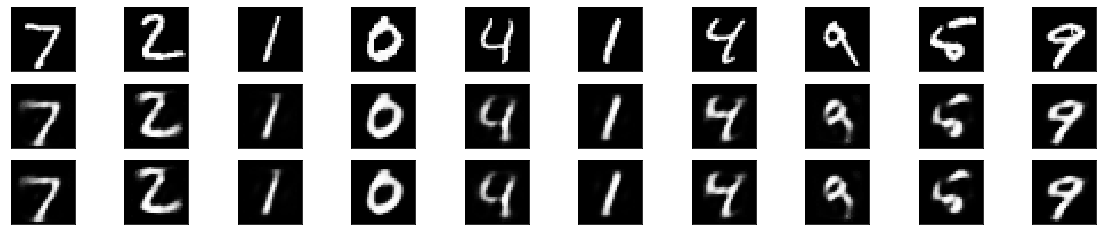

In [58]:
n = 10  # how many digits we will display
_=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    _=plt.imshow(x_test[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    _=plt.imshow(decoded_imgs[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    #_=plt.imshow(decoded_imgs[i].reshape(28, 28))
    _=plt.imshow(autoencoder_imgs[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
_=plt.show()

## Sparse Autoencoders

another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [87]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=regularizers.l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adadelta', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=50, verbose=False)

In [88]:
reconstructed= autoencoder_regularized.predict(x_test)

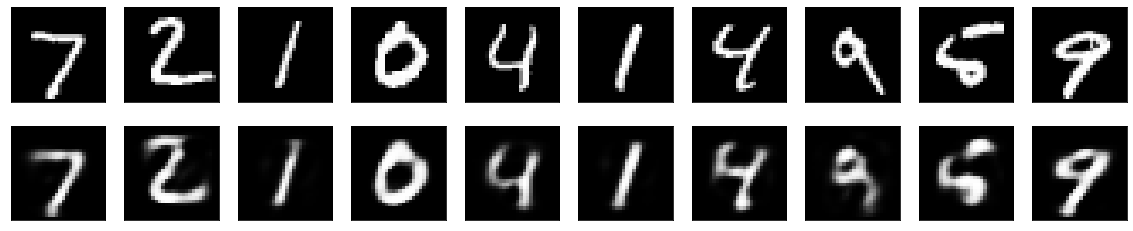

In [89]:
n = 10  # how many digits we will display
_=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    _=plt.imshow(x_test[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    _=plt.imshow(reconstructed[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Ejemplo con mas neuronas en la capa de code.

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape
x_test.shape

input_size = 784
code_size = 1024

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=regularizers.l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adadelta', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=50)

reconstructed= autoencoder_regularized.predict(x_test)

n = 10  # how many digits we will display
_=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    _=plt.imshow(x_test[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    _=plt.imshow(reconstructed[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [90]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
output_img = Dense(784, activation='sigmoid')(decoded)

In [93]:
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=False,
                validation_data=(x_test, x_test))

In [94]:
reconstructed= autoencoder.predict(x_test)

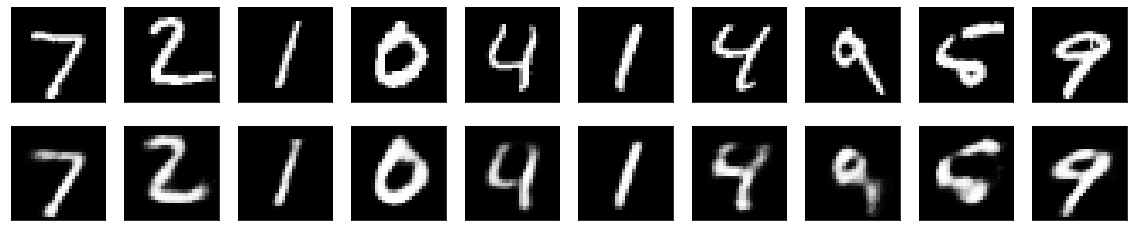

In [95]:
n = 10  # how many digits we will display
_=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    _=plt.imshow(x_test[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    _=plt.imshow(reconstructed[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

In [107]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [108]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [109]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 74s 1ms/step - loss: 0.2080 - val_loss: 0.1581
Epoch 2/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1516 - val_loss: 0.1431
Epoch 3/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1392 - val_loss: 0.1430
Epoch 4/50
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1326 - val_loss: 0.1294
Epoch 5/50
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1283 - val_loss: 0.1233
Epoch 6/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1249 - val_loss: 0.1246
Epoch 7/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1218 - val_loss: 0.1245
Epoch 8/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1194 - val_loss: 0.1151
Epoch 9/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1174 - val_loss: 0.1175
Epoch

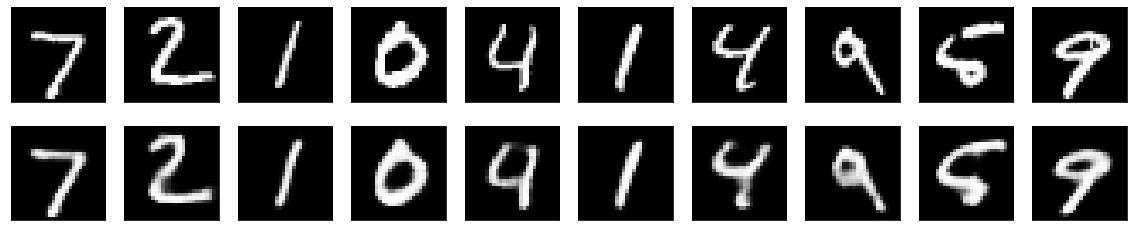

In [111]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
_=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    _=plt.imshow(x_test[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 +n)
    _=plt.imshow(decoded_imgs[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
_=plt.show()

## Application to image denoising

In [112]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

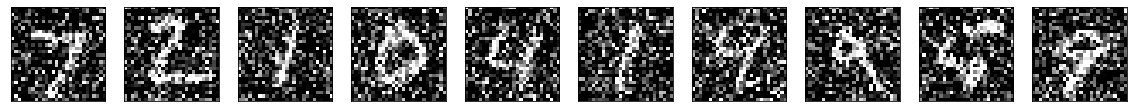

In [115]:
n = 10
_=plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    _=plt.imshow(x_test_noisy[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
_=plt.show()

In [118]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [119]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1773 - val_loss: 0.1233
Epoch 2/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1202 - val_loss: 0.1163
Epoch 3/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1121 - val_loss: 0.1095
Epoch 4/50
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1080 - val_loss: 0.1082
Epoch 5/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1056 - val_loss: 0.1051
Epoch 6/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1042 - val_loss: 0.1026
Epoch 7/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1029 - val_loss: 0.1026
Epoch 8/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1022 - val_loss: 0.1008
Epoch 9/50
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1014 - val_loss: 0.1

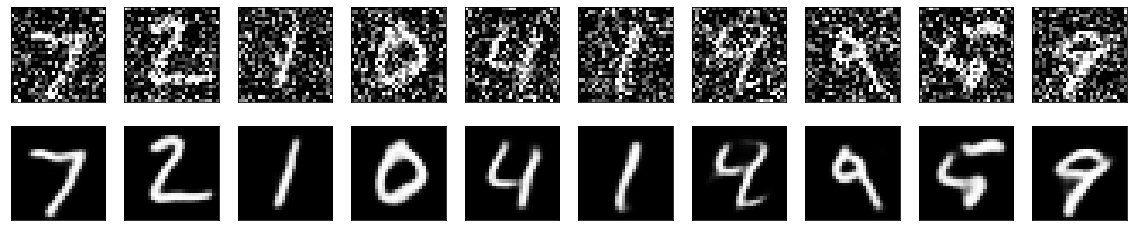

In [120]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
_=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    _=plt.imshow(x_test_noisy[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 +n)
    _=plt.imshow(decoded_imgs[i].reshape(28, 28))
    _=plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
_=plt.show()

In [ ]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
# para generacion de mas muestras a partir de las existentes.

#encoders variacionales
#https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73 (tutorial)